# Homework 3. 
# I. Decision Tree.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [2]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [3]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [4]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [6]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [7]:
data = X_train.copy()
data['target'] = y_train #здесь я создаю столбец target, чтобы считать IG по нему, предварительно отсортировав по признаку
data.head()              #Заранее извиняюсь, что сделал новый датафрейм. Переживал, что не будет понятно, откуда в X_train столбец target

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,target
299,50.0,247.5208,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
647,56.0,35.5000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
476,34.0,21.0000,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
390,36.0,120.0000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
473,23.0,13.7917,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
def get_target(series):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """

    # YOUR CODE HERE
    zero_num = (series == 0).sum() #просто считаем количество нулей в pd.Series
    one_num = (series == 1).sum() #аналогично для единиц
    print('zero = ',zero_num)
    print('one = ',one_num)
    if zero_num > one_num:
        return 0
    else:
        return 1
    #return None
    
get_target(data.target)

zero =  490
one =  311


0

In [9]:
def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE                                              #Ищем уникальные значения в столбце: то есть [0,1], делим их количество в
    prob = np.unique(target,return_counts = True)[1]/len(target)  #в столбце на длину всего столбца - получаем вероятность. Дальше считаем
    entropy = np.sum(-np.multiply(prob,np.log2(prob)))            #entropy по формуле энтропии Шенона из лекции
    
    return entropy

get_entropy(data.target)

0.9636705427434455

In [10]:
def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    df_sorted = df.sort_values(by  = [f_name], ascending = False) #сортируем df по выбранной фиче
    s_0 = get_entropy(data.target) #ищем энтропию target
    maximum = 0
    ind = 0
    if df[f_name].value_counts().count() != 2: #для небинарных фичей Age и Fare проходим по всему target и ищем max(IG)
        for i in range(len(df.target) - 1):
            s_1 = df_sorted.target[:i + 1]
            s_2 = df_sorted.target[i + 1:]
            IG = s_0 - len(s_1)/len(df.target)*get_entropy(s_1) - len(s_2)/len(df.target)*get_entropy(s_2)
            if IG > maximum:
                maximum = IG
                ind = float(df_sorted[f_name][i+1:i+2].values) #возвращаем значение фичи, при котором IG максимальный
    else:                                     #а здесь уже для бинарных фичей считаем IG в месте, где в фиче закнчиваются 1 и начинаются 0
        for i in range(len(df.target) - 1):
            if int(df_sorted[f_name][i:i+1].values) > int(df_sorted[f_name][i+1:i+2].values):
                s_1 = df_sorted.target[:i + 1]
                s_2 = df_sorted.target[i + 1:]
                maximum = s_0 - len(s_1)/len(df.target)*get_entropy(s_1) - len(s_2)/len(df.target)*get_entropy(s_2)
                ind = 0
    
    delta_entropy = maximum
    threshold = ind
    
    return (delta_entropy, threshold)

feature_separation(data, 'Age')

(0.014927641480743582, 6.0)

In [11]:
data[data['Parch_6']!=0] #здесь видно, что столбец Parch_6 тождественные нули. Вообще его можно выбросить, но это никак не повлияет на дерево.

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,target


In [12]:
all_features = [c for c in df.columns.tolist() if c != 'target'] #для наглядности вывел IG при первом разбиении по каждой фиче
for f in all_features:
    print('Name:',f,' fs =',feature_separation(data,f))

Name: Age  fs = (0.014927641480743582, 6.0)
Name: Fare  fs = (0.061784602677567024, 15.5)
Name: Pclass_2  fs = (0.00309632329790821, 0)
Name: Pclass_3  fs = (0.06922539314430137, 0)
Name: Sex_male  fs = (0.212023978502217, 0)
Name: SibSp_1  fs = (0.022386157691814956, 0)
Name: SibSp_2  fs = (0.0009006624222953619, 0)
Name: SibSp_3  fs = (0.0017758141112800274, 0)
Name: SibSp_4  fs = (0.0038591527236849776, 0)
Name: SibSp_5  fs = (0.003552144257329415, 0)
Name: SibSp_8  fs = (0.00623142034243096, 0)
Name: Parch_1  fs = (0.010670942328327992, 0)
Name: Parch_2  fs = (0.0025971838247031975, 0)
Name: Parch_3  fs = (0.001955747309524747, 0)
Name: Parch_4  fs = (0.003552144257329415, 0)
Name: Parch_5  fs = (0.0007424577999274318, 0)
Name: Parch_6  fs = (0.007757008614644428, 0.0)
Name: Embarked_Q  fs = (0.0004072420591217929, 0)
Name: Embarked_S  fs = (0.02048037461135438, 0)


In [13]:
def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, df
    all_features = [c for c in df.columns.tolist() if c != 'target']
    
    maximum = 0
    for f in all_features:
        # YOUR CODE HERE
        cort = feature_separation(df, f) 
        if cort[0] > maximum:   #выбираем фичу с максимальным IG на данном этапе
            maximum = cort[0]
            sep_feature = f
            threshold = cort[1]
            if type(threshold) == int: #если фича бинарная, то разбиваем по значения этой фичи: все единицы - одно поддерево,
                groups = (df[df[f] == 0],df[df[f] == 1])      #все нули - другое.
            else:                                             #если фича не бинарная, то бьем дерево по thershold: все значения >= 
                groups = (df[df[f] < threshold],df[df[f] >= threshold]) #threshold - одно поддерево, все значения < - другое
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}

print(best_separation(data))


{'feature_name': 'Sex_male', 'threshold': 0, 'groups': (      Age      Fare  Pclass_2  Pclass_3  Sex_male  SibSp_1  SibSp_2  SibSp_3  \
299  50.0  247.5208         0         0         0        0        0        0   
473  23.0   13.7917         1         0         0        0        0        0   
763  36.0  120.0000         0         0         0        1        0        0   
237   8.0   26.2500         1         0         0        0        0        0   
501  21.0    7.7500         0         1         0        0        0        0   
..    ...       ...       ...       ...       ...      ...      ...      ...   
820  52.0   93.5000         0         0         0        1        0        0   
229  28.0   25.4667         0         1         0        0        0        1   
638  41.0   39.6875         0         1         0        0        0        0   
866  27.0   13.8583         1         0         0        1        0        0   
742  21.0  262.3750         0         0         0        0      

In [14]:
def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    #print(df_left)
    #print(df_right)
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
            print('проверяем, есть ли разбиение')  #сюда попадаем, когда лист уже состоит только из значений 1 или 0, но глубина < max_depth
            node['left'] = node['right'] = pd.concat([df_left,df_right]) #поэтому к какому-то классу этот лист мы уже отнесли, значит нужно
            return                                                      #передавать объединенный датафрейм (пустой + непустой)
    # проверяем максимальную глубину
    if depth >= max_depth:
        print('проверяем максимальную глубину = ',depth) #сюда попадаем, если достигли max_depth, значит дерево бить дальше не надо. Поэтому
        node['left'], node['right'] = get_target(df_left.target), get_target(df_right.target) # присваиваем листам какое-то значение
        print("node['left'], node['right']",node['left'], node['right'])
        return 
    
    else:
        node['left'] = best_separation(df_left) # еще не добразбили дерево до конца - повторяем операцию для поддерева
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right) # YOUR CODE HERE
        split(node['right'], max_depth, depth + 1)

In [15]:
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [16]:
my_tree = fit_my_tree(data, 3) #здесь я кратенько посмотрел, как разбилось дерево. Получили 8 листов, 5 из которых "выжили", и 3 - "умерли"

проверяем максимальную глубину =  3
zero =  6
one =  53
zero =  3
one =  90
node['left'], node['right'] 1 1
проверяем максимальную глубину =  3
zero =  44
one =  63
zero =  19
one =  3
node['left'], node['right'] 1 0
проверяем максимальную глубину =  3
zero =  2
one =  11
zero =  314
one =  38
node['left'], node['right'] 1 0
проверяем максимальную глубину =  3
zero =  0
one =  2
zero =  102
one =  51
node['left'], node['right'] 1 0


## Predict MyDecisionTree  

In [17]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [18]:
data_test = X_test.copy()

In [19]:
my_pred_test = predict_my_tree(data_test,my_tree)
print('Предсказанное число погибших (test) = ',my_pred_test.sum()) #здесь я решил сравнить фактическое и предсказанное число погибших
print('Фактическое число погибших (test)=',y_test.sum())           #на train и test
my_pred_train = predict_my_tree(data,my_tree)
print('Предсказанное число погибших (train) = ',my_pred_train.sum())
print('Фактическое число погибших (train)=',y_train.sum())

Предсказанное число погибших (test) =  31
Фактическое число погибших (test)= 31


<ipython-input-17-502e52ba210a>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


Предсказанное число погибших (train) =  281
Фактическое число погибших (train)= 311


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [20]:
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [21]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

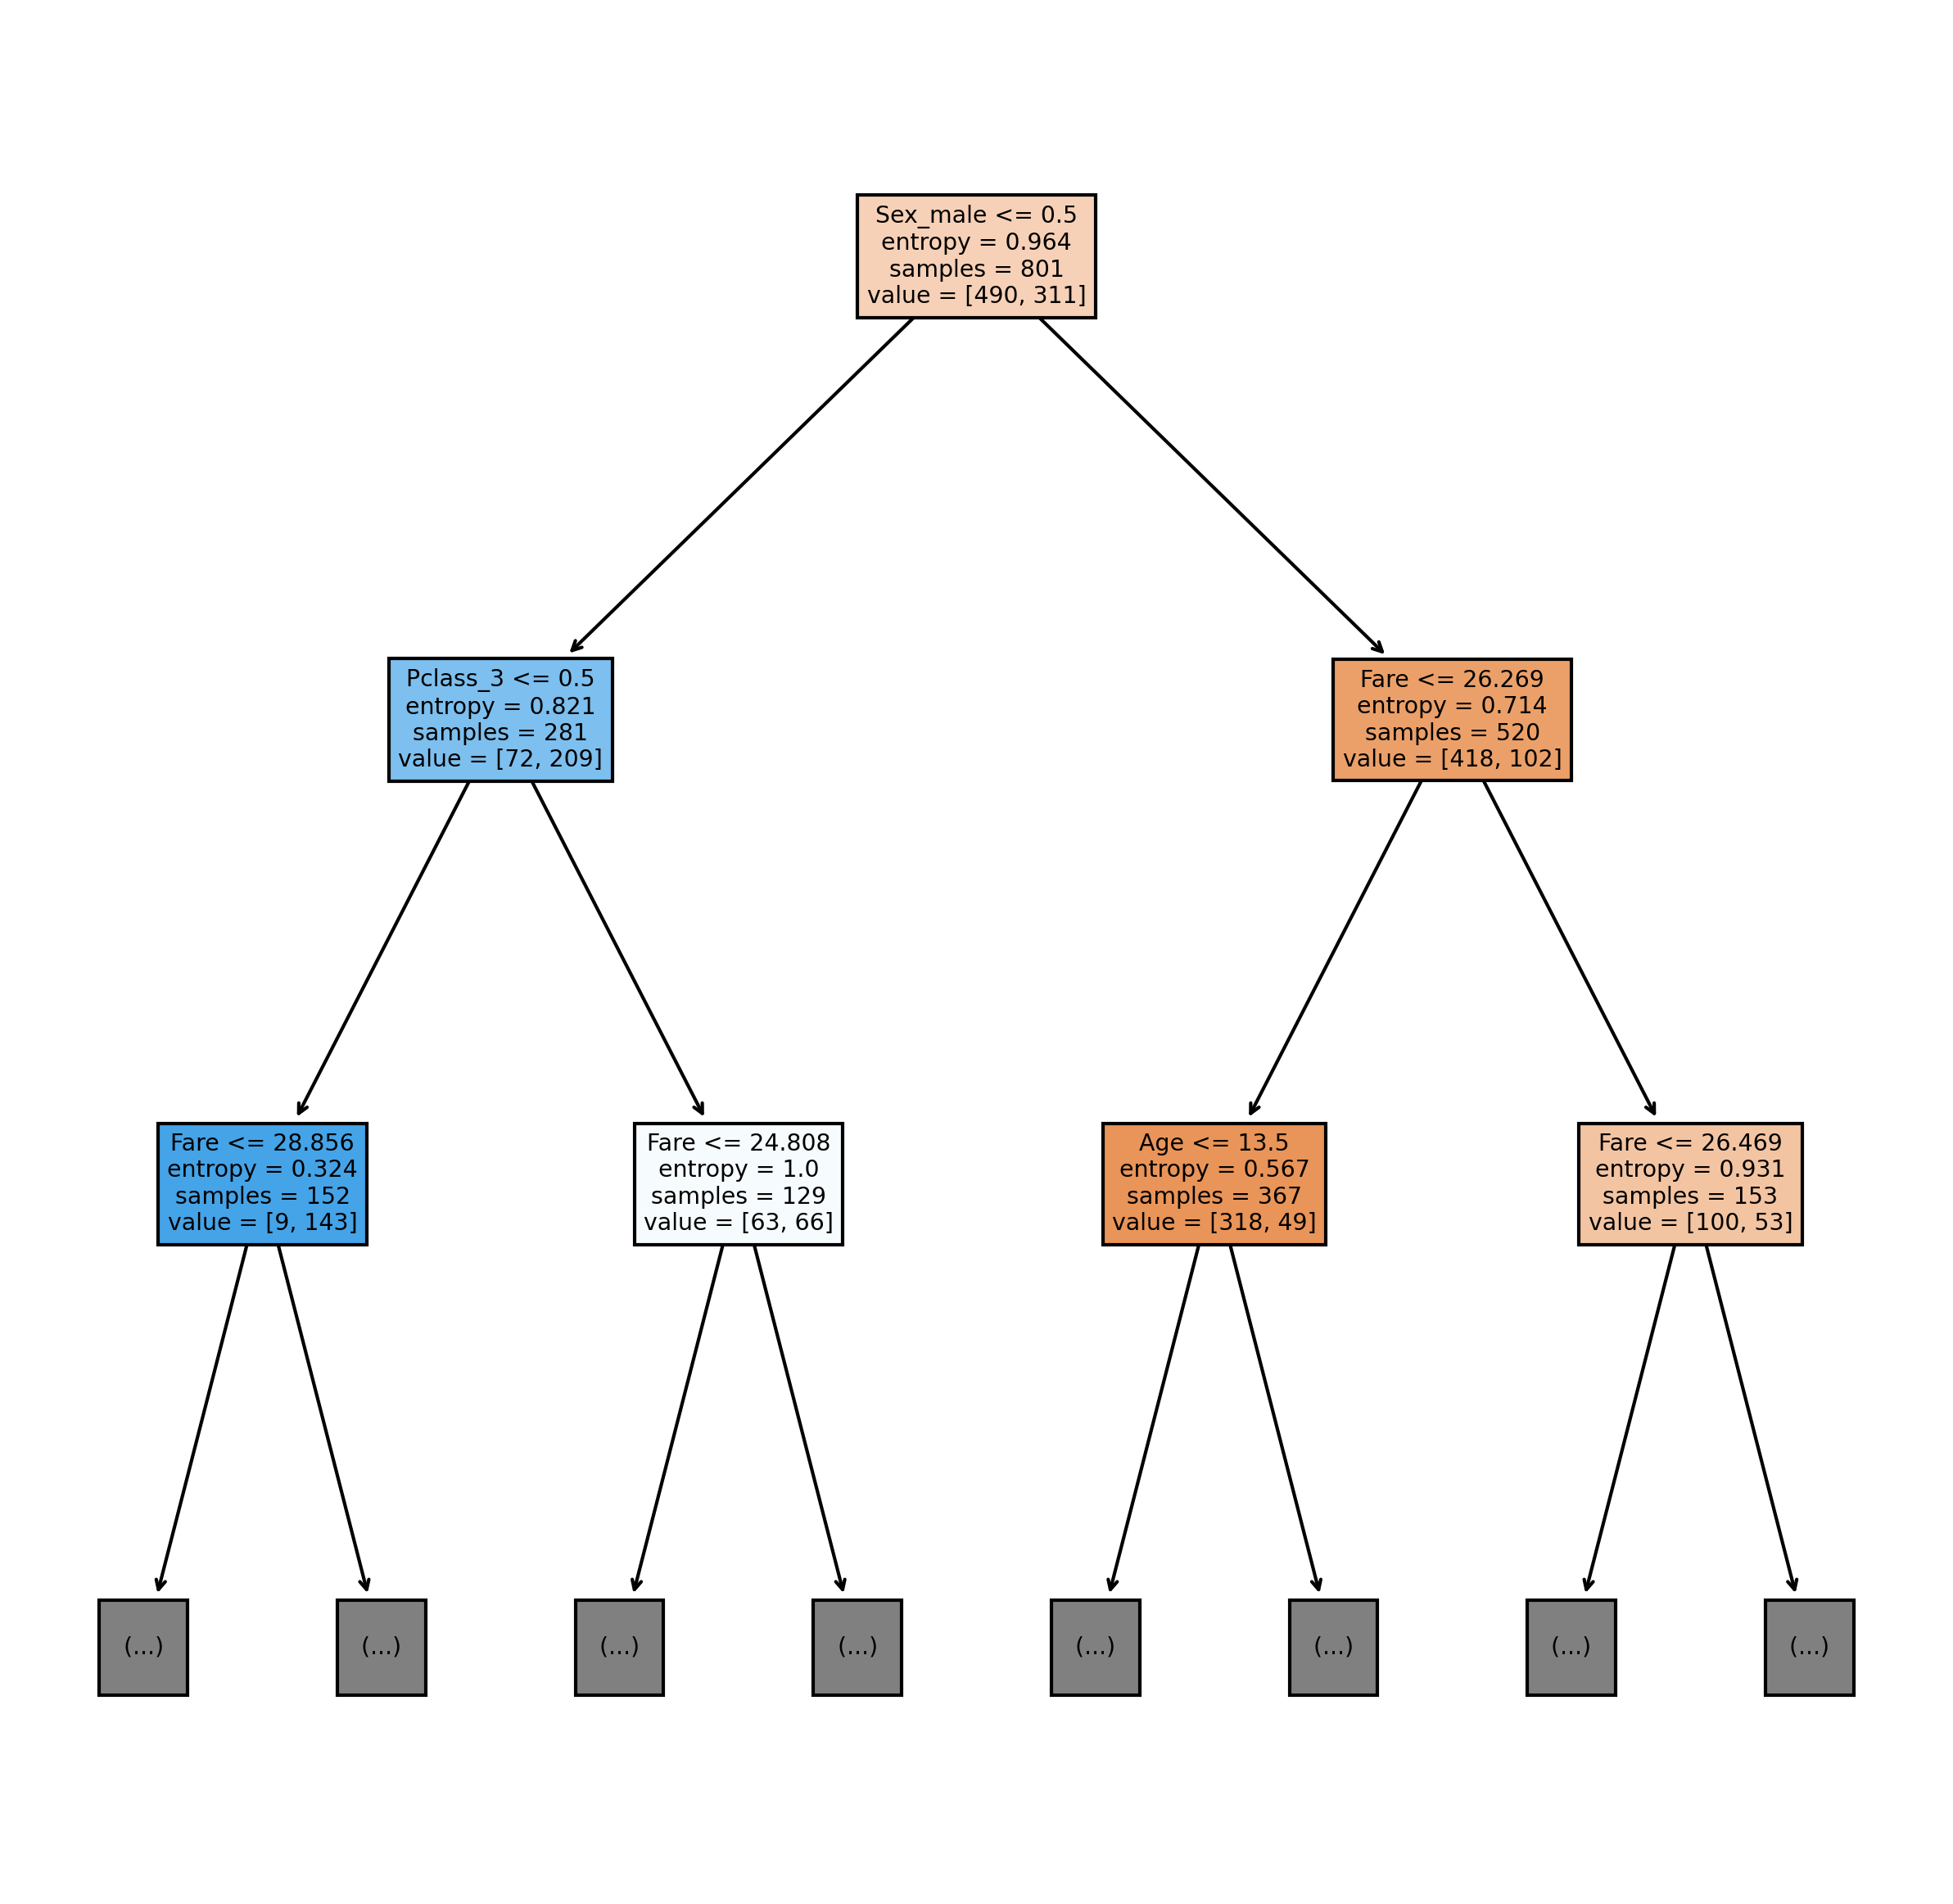

In [25]:
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
fig.set(facecolor = 'white')
sklearn.tree.plot_tree(clf_tree, max_depth = 2, feature_names = X_train.columns, filled = True);

## Сравнение метрик

In [23]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

#print(skl_roc_train, skl_roc_test)
#print(my_roc_train, my_roc_test)

In [24]:
assert abs(my_roc_test - 0.6) >= 0.2